# botorch_functions

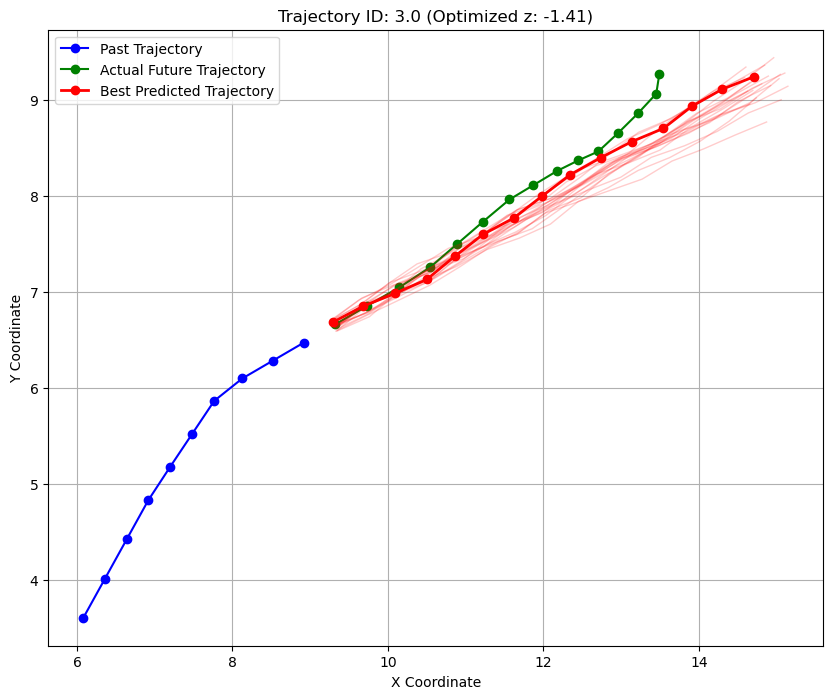

In [2]:
# Imports (as provided) 
import torch
import torch.nn as nn
import math
import os
import pandas as pd  # For reading data
import numpy as np
from typing import Any, Dict, List, NamedTuple, Optional, Tuple, Union

# Ensure duplicate libraries don't cause issues
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

# Set default tensor type to double precision
torch.set_default_dtype(torch.double)

# BoTorch and GPyTorch imports
from torch.optim.optimizer import Optimizer
from botorch.acquisition.acquisition import AcquisitionFunction
from gpytorch.mlls.marginal_log_likelihood import MarginalLogLikelihood
from botorch.models import SingleTaskGP
from botorch.acquisition import qExpectedImprovement, qUpperConfidenceBound
from botorch.sampling import SobolQMCNormalSampler
from botorch.utils.transforms import (
    concatenate_pending_points,
    t_batch_mode_transform,
)
from botorch.acquisition.monte_carlo import MCAcquisitionFunction
from botorch.acquisition.objective import (
    MCAcquisitionObjective,
    PosteriorTransform,
)
from botorch.optim.optimize import optimize_acqf
from gpytorch.mlls import ExactMarginalLogLikelihood
from gpytorch import settings as gpt_settings
from torch.optim import Adam
from torch import Tensor
from inspect import signature
import time

# Import for visualization
import matplotlib.pyplot as plt


def optimize_acquisition_function(
    acquisition_function: AcquisitionFunction,
    bounds: Tensor,
    num_restarts: int,
    raw_samples: int,
    num_candidates: int,
    optimizer_options: Optional[Dict[str, Any]] = None,
) -> Tensor:
    """
    Optimizes the acquisition function to find the next set of candidates.

    Args:
        acquisition_function (AcquisitionFunction): The acquisition function to optimize.
        bounds (Tensor): A tensor containing the lower and upper bounds.
        num_restarts (int): Number of restarts for optimization.
        raw_samples (int): Number of raw samples to use for initialization.
        num_candidates (int): Number of candidates to generate.
        optimizer_options (Optional[Dict[str, Any]]): Options for the optimizer.

    Returns:
        Tensor: The optimized candidate points.
    """
    from botorch.optim.optimize import optimize_acqf

    # Use BoTorch's built-in optimizer for acquisition functions
    candidates, _ = optimize_acqf(
        acq_function=acquisition_function,
        bounds=bounds,
        q=num_candidates,
        num_restarts=num_restarts,
        raw_samples=raw_samples,
        options=optimizer_options or {},
    )
    return candidates

def one_step_bayesian_optimization(
    train_x: Tensor,
    train_y: Tensor,
    bounds: Tensor,
    num_candidates: int,
    acquisition_function_type: str = "EI",
    acq_function_kwargs: Optional[Dict[str, Any]] = None,
    optimizer_options: Optional[Dict[str, Any]] = None,
) -> Tensor:
    # Use BoTorch's built-in model fitting function
    from botorch.fit import fit_gpytorch_model

    model = SingleTaskGP(train_x, train_y)
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    fit_gpytorch_model(mll)  # Improved model fitting

    # Increase restarts and raw samples for better optimization
    num_restarts = 20
    raw_samples = 512

    if acquisition_function_type == "EI":
        acq_func = qExpectedImprovement(
            model=model,
            best_f=train_y.max(),
            sampler=SobolQMCNormalSampler(num_samples=500),
            **(acq_function_kwargs or {})
        )
    elif acquisition_function_type == "UCB":
        acq_func = qUpperConfidenceBound(
            model=model,
            beta=acq_function_kwargs.get("beta", 0.1),
            sampler=SobolQMCNormalSampler(num_samples=500),
        )
    else:
        raise ValueError("Unsupported acquisition function type.")
    candidates = optimize_acquisition_function(
        acquisition_function=acq_func,
        bounds=bounds,
        num_restarts=num_restarts,
        raw_samples=raw_samples,
        num_candidates=num_candidates,
        optimizer_options=optimizer_options,
    )
    return candidates

class Generator:
    """
    Mock generator for generating 2D predictions based on latent variable z.
    In practice, replace this with a pre-trained model.
    """
    def predict(
        self, X, z, num_future_steps, randomness_factor=0.01, angle_range_deg=(-10, 10)
    ):
        # Calculate the difference between consecutive points (finite difference)
        dx = X[1:, 0] - X[:-1, 0]  # Change in x-coordinates
        dy = X[1:, 1] - X[:-1, 1]  # Change in y-coordinates

        # Compute the tangents (directions) and their magnitudes (step sizes)
        tangents = torch.stack((dx, dy), dim=-1)  # Shape: (N_past - 1, 2)
        magnitudes = torch.norm(tangents, dim=-1, keepdim=True)  # Shape: (N_past - 1, 1)
        directions = tangents / magnitudes  # Unit vectors, Shape: (N_past - 1, 2)

        # Use the last tangent's direction and magnitude for future steps
        last_direction = directions[-1]  # Shape: (2,)
        last_magnitude = magnitudes[-1]  # Shape: (1,)

        # Convert angle range from degrees to radians
        min_angle_rad = torch.tensor(angle_range_deg[0] * torch.pi / 180)
        max_angle_rad = torch.tensor(angle_range_deg[1] * torch.pi / 180)

        # Generate random angles for future steps
        angles = torch.rand(num_future_steps) * (max_angle_rad - min_angle_rad) + min_angle_rad  # Shape: (num_future_steps,)

        # Rotation matrix for 2D
        rotation_matrix = torch.stack(
            [torch.cos(angles), -torch.sin(angles), torch.sin(angles), torch.cos(angles)], dim=-1
        ).view(-1, 2, 2)  # Shape: (num_future_steps, 2, 2)

        # Repeat last_direction for num_future_steps
        directions_future = last_direction.unsqueeze(0).repeat(num_future_steps, 1)  # Shape: (num_future_steps, 2)

        # Rotate the directions by applying the rotation matrix
        randomized_directions = torch.matmul(rotation_matrix, directions_future.unsqueeze(-1)).squeeze(-1)  # Shape: (num_future_steps, 2)

        # Adjust the magnitudes based on the latent variable z
        z = z.view(-1, 1)  # Ensure z has a dimension for broadcasting
        # Adjust magnitudes (step sizes) rather than directions
        adjusted_magnitudes = last_magnitude * (1 + randomness_factor * z)  # Shape: (1,)

        # Ensure adjusted_magnitudes has the correct shape
        adjusted_magnitudes = adjusted_magnitudes.expand(num_future_steps, 1)  # Shape: (num_future_steps, 1)

        # Compute adjusted tangents (directions * adjusted magnitudes)
        adjusted_tangents = randomized_directions * adjusted_magnitudes  # Shape: (num_future_steps, 2)

        # Generate the future trajectory
        future_trajectory = torch.zeros(num_future_steps, 2, dtype=X.dtype)
        future_trajectory[0] = X[-1] + adjusted_tangents[0]  # Start from the last point of X

        # Accumulate adjusted tangents to generate the future path
        for i in range(1, num_future_steps):
            future_trajectory[i] = future_trajectory[i - 1] + adjusted_tangents[i]

        return future_trajectory

# Read the data from a text file
data = pd.read_csv('src/datasets/hotel/train/students003_train.txt', sep='\t', header=None)

# Assign column names
data.columns = ['frame_number', 'ID', 'x_coord', 'y_coord']

# Group data by ID
grouped = data.groupby('ID')

# Initialize the generator
generator = Generator()

# Set the number of past and future points
N_past = 10
N_future = 15  # Number of future steps to predict

# Initialize lists to collect training data for Bayesian optimization
train_x = []
train_y = []

# Bounds for z
z_lower_bound = -5.0
z_upper_bound = 5.0
bounds = torch.tensor([[z_lower_bound], [z_upper_bound]], dtype=torch.double)

# Process trajectories
for ID, group in grouped:
    group = group.sort_values('frame_number')
    X = torch.tensor(group[['x_coord', 'y_coord']].values)

    # Ensure there are enough points for past and future
    if len(X) >= N_past + N_future:
        X_past = X[:N_past]
        Y_future = X[N_past:N_past+N_future]

        # Objective function to minimize (e.g., MSE between predicted and actual future)
        def objective(z):
            z_tensor = torch.tensor([z], dtype=torch.double)
            pred_future = generator.predict(
                X_past, z_tensor, num_future_steps=N_future, randomness_factor=0.0
            )  # Set randomness_factor=0.0 for determinism
            loss = torch.nn.functional.mse_loss(pred_future, Y_future)
            return loss.item()

        # Collect initial data points for z and corresponding objective values
        initial_z = torch.linspace(z_lower_bound, z_upper_bound, steps=5)
        initial_obj = []
        for z in initial_z:
            loss = objective(z.item())
            train_x.append([z.item()])
            train_y.append([loss])

        # Convert training data to tensors
        train_x_tensor = torch.tensor(train_x, dtype=torch.double)
        train_y_tensor = torch.tensor(train_y, dtype=torch.double)

        # Remove scaling: Use the original data directly
        # The scaling steps are commented out or removed

        # Define bounds (no scaling)
        bounds_tensor = bounds

        # Number of candidates to propose
        num_candidates = 20

        # Perform one step of Bayesian Optimization to find the best z
        candidates = one_step_bayesian_optimization(
            train_x=train_x_tensor,
            train_y=train_y_tensor,
            bounds=bounds_tensor,
            num_candidates=num_candidates,
            acquisition_function_type='EI',
            acq_function_kwargs=None,
            optimizer_options={'disp': True, 'maxiter': 500}
        )

        # Since we didn't scale, candidates are already in the original scale
        candidate_z_np = candidates.detach().numpy()
        best_z = candidate_z_np[0, 0]

        # Generate predictions for all candidates
        predicted_futures = []
        for z_value in candidate_z_np:
            z_tensor = torch.tensor([z_value[0]], dtype=torch.double)
            pred_future = generator.predict(
                X_past, z_tensor, num_future_steps=N_future, randomness_factor=0.01
            )
            predicted_futures.append(pred_future)

        # Plot the past trajectory and actual future trajectory
        plt.figure(figsize=(10, 8))
        plt.plot(X_past[:, 0], X_past[:, 1], 'bo-', label='Past Trajectory')
        plt.plot(Y_future[:, 0], Y_future[:, 1], 'go-', label='Actual Future Trajectory')

        # Plot predicted future trajectories for all candidates
        for i, pred_future in enumerate(predicted_futures):
            # Plot with semi-transparent lines
            plt.plot(
                pred_future[:, 0],
                pred_future[:, 1],
                color='red',
                alpha=0.2,
                linewidth=1
            )

        # Optionally, highlight the best prediction
        best_pred_future = predicted_futures[0]
        plt.plot(
            best_pred_future[:, 0],
            best_pred_future[:, 1],
            'ro-',
            label='Best Predicted Trajectory',
            linewidth=2
        )

        plt.legend()
        plt.title(f'Trajectory ID: {ID} (Optimized z: {best_z:.2f})')
        plt.xlabel('X Coordinate')
        plt.ylabel('Y Coordinate')
        plt.grid(True)
        plt.show()

        # For demonstration, process only one trajectory
        break


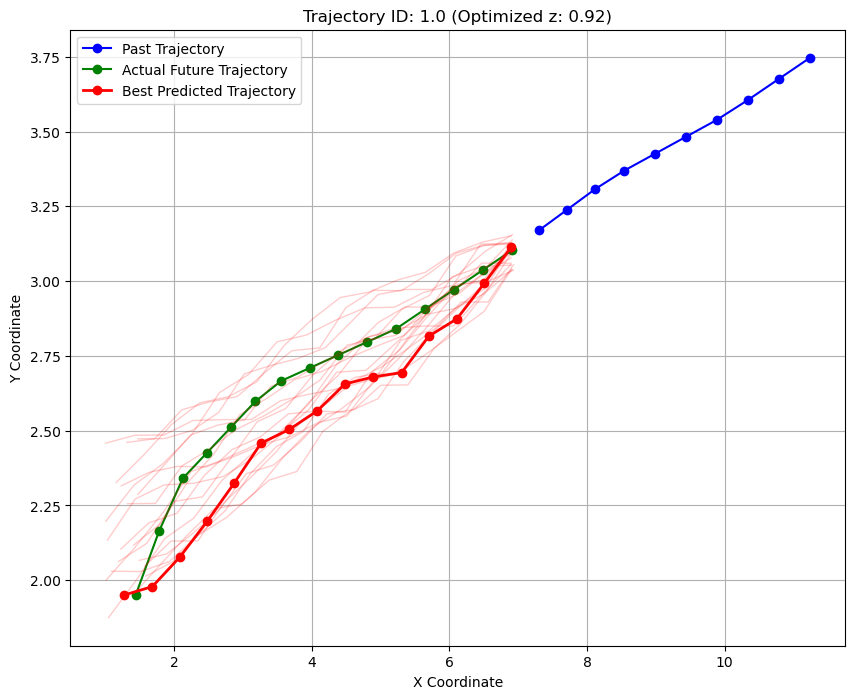

In [5]:

# Read the data from a text file
data = pd.read_csv('src/datasets/hotel/train/students001_train.txt', sep='\t', header=None)

# Assign column names
data.columns = ['frame_number', 'ID', 'x_coord', 'y_coord']

# Group data by ID
grouped = data.groupby('ID')

# Initialize the generator
generator = Generator()

# Set the number of past and future points
N_past = 10
N_future = 15  # Number of future steps to predict

# Initialize lists to collect training data for Bayesian optimization
train_x = []
train_y = []

# Bounds for z
z_lower_bound = -5.0
z_upper_bound = 5.0
bounds = torch.tensor([[z_lower_bound], [z_upper_bound]], dtype=torch.double)

# Process trajectories
for ID, group in grouped:
    group = group.sort_values('frame_number')
    X = torch.tensor(group[['x_coord', 'y_coord']].values)

    # Ensure there are enough points for past and future
    if len(X) >= N_past + N_future:
        X_past = X[:N_past]
        Y_future = X[N_past:N_past+N_future]

        # Objective function to minimize (e.g., MSE between predicted and actual future)
        def objective(z):
            z_tensor = torch.tensor([z], dtype=torch.double)
            pred_future = generator.predict(
                X_past, z_tensor, num_future_steps=N_future, randomness_factor=0.0
            )  # Set randomness_factor=0.0 for determinism
            loss = torch.nn.functional.mse_loss(pred_future, Y_future)
            return loss.item()

        # Collect initial data points for z and corresponding objective values
        initial_z = torch.linspace(z_lower_bound, z_upper_bound, steps=5)
        initial_obj = []
        for z in initial_z:
            loss = objective(z.item())
            train_x.append([z.item()])
            train_y.append([loss])

        # Convert training data to tensors
        train_x_tensor = torch.tensor(train_x, dtype=torch.double)
        train_y_tensor = torch.tensor(train_y, dtype=torch.double)

        # Remove scaling: Use the original data directly
        # The scaling steps are commented out or removed

        # Define bounds (no scaling)
        bounds_tensor = bounds

        # Number of candidates to propose
        num_candidates = 20

        # Perform one step of Bayesian Optimization to find the best z
        candidates = one_step_bayesian_optimization(
            train_x=train_x_tensor,
            train_y=train_y_tensor,
            bounds=bounds_tensor,
            num_candidates=num_candidates,
            acquisition_function_type='EI',
            acq_function_kwargs=None,
            optimizer_options={'disp': True, 'maxiter': 500}
        )

        # Since we didn't scale, candidates are already in the original scale
        candidate_z_np = candidates.detach().numpy()
        best_z = candidate_z_np[0, 0]

        # Generate predictions for all candidates
        predicted_futures = []
        for z_value in candidate_z_np:
            z_tensor = torch.tensor([z_value[0]], dtype=torch.double)
            pred_future = generator.predict(
                X_past, z_tensor, num_future_steps=N_future, randomness_factor=0.01
            )
            predicted_futures.append(pred_future)

        # Plot the past trajectory and actual future trajectory
        plt.figure(figsize=(10, 8))
        plt.plot(X_past[:, 0], X_past[:, 1], 'bo-', label='Past Trajectory')
        plt.plot(Y_future[:, 0], Y_future[:, 1], 'go-', label='Actual Future Trajectory')

        # Plot predicted future trajectories for all candidates
        for i, pred_future in enumerate(predicted_futures):
            # Plot with semi-transparent lines
            plt.plot(
                pred_future[:, 0],
                pred_future[:, 1],
                color='red',
                alpha=0.2,
                linewidth=1
            )

        # Optionally, highlight the best prediction
        best_pred_future = predicted_futures[0]
        plt.plot(
            best_pred_future[:, 0],
            best_pred_future[:, 1],
            'ro-',
            label='Best Predicted Trajectory',
            linewidth=2
        )

        plt.legend()
        plt.title(f'Trajectory ID: {ID} (Optimized z: {best_z:.2f})')
        plt.xlabel('X Coordinate')
        plt.ylabel('Y Coordinate')
        plt.grid(True)
        plt.show()

        # For demonstration, process only one trajectory
        break


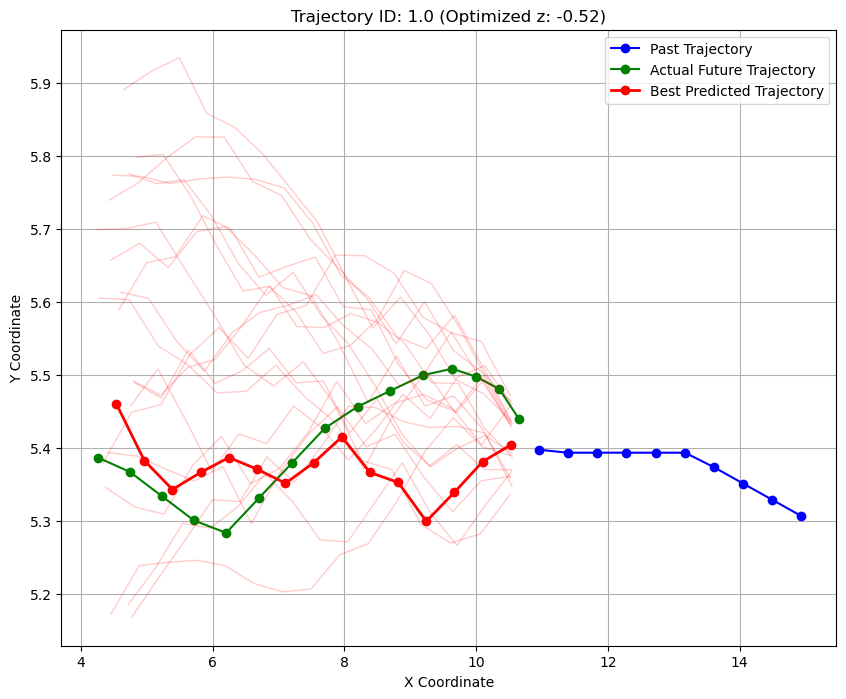

In [12]:

# Read the data from a text file
data = pd.read_csv('src/datasets/hotel/train/crowds_zara02_train.txt', sep='\t', header=None)

# Assign column names
data.columns = ['frame_number', 'ID', 'x_coord', 'y_coord']

# Group data by ID
grouped = data.groupby('ID')

# Initialize the generator
generator = Generator()

# Set the number of past and future points
N_past = 10
N_future = 15  # Number of future steps to predict

# Initialize lists to collect training data for Bayesian optimization
train_x = []
train_y = []

# Bounds for z
z_lower_bound = -5.0
z_upper_bound = 5.0
bounds = torch.tensor([[z_lower_bound], [z_upper_bound]], dtype=torch.double)

# Process trajectories
for ID, group in grouped:
    group = group.sort_values('frame_number')
    X = torch.tensor(group[['x_coord', 'y_coord']].values)

    # Ensure there are enough points for past and future
    if len(X) >= N_past + N_future:
        X_past = X[:N_past]
        Y_future = X[N_past:N_past+N_future]

        # Objective function to minimize (e.g., MSE between predicted and actual future)
        def objective(z):
            z_tensor = torch.tensor([z], dtype=torch.double)
            pred_future = generator.predict(
                X_past, z_tensor, num_future_steps=N_future, randomness_factor=0.0
            )  # Set randomness_factor=0.0 for determinism
            loss = torch.nn.functional.mse_loss(pred_future, Y_future)
            return loss.item()

        # Collect initial data points for z and corresponding objective values
        initial_z = torch.linspace(z_lower_bound, z_upper_bound, steps=5)
        initial_obj = []
        for z in initial_z:
            loss = objective(z.item())
            train_x.append([z.item()])
            train_y.append([loss])

        # Convert training data to tensors
        train_x_tensor = torch.tensor(train_x, dtype=torch.double)
        train_y_tensor = torch.tensor(train_y, dtype=torch.double)

        # Remove scaling: Use the original data directly
        # The scaling steps are commented out or removed

        # Define bounds (no scaling)
        bounds_tensor = bounds

        # Number of candidates to propose
        num_candidates = 20

        # Perform one step of Bayesian Optimization to find the best z
        candidates = one_step_bayesian_optimization(
            train_x=train_x_tensor,
            train_y=train_y_tensor,
            bounds=bounds_tensor,
            num_candidates=num_candidates,
            acquisition_function_type='EI',
            acq_function_kwargs=None,
            optimizer_options={'disp': True, 'maxiter': 500}
        )

        # Since we didn't scale, candidates are already in the original scale
        candidate_z_np = candidates.detach().numpy()
        best_z = candidate_z_np[0, 0]

        # Generate predictions for all candidates
        predicted_futures = []
        for z_value in candidate_z_np:
            z_tensor = torch.tensor([z_value[0]], dtype=torch.double)
            pred_future = generator.predict(
                X_past, z_tensor, num_future_steps=N_future, randomness_factor=0.01
            )
            predicted_futures.append(pred_future)

        # Plot the past trajectory and actual future trajectory
        plt.figure(figsize=(10, 8))
        plt.plot(X_past[:, 0], X_past[:, 1], 'bo-', label='Past Trajectory')
        plt.plot(Y_future[:, 0], Y_future[:, 1], 'go-', label='Actual Future Trajectory')

        # Plot predicted future trajectories for all candidates
        for i, pred_future in enumerate(predicted_futures):
            # Plot with semi-transparent lines
            plt.plot(
                pred_future[:, 0],
                pred_future[:, 1],
                color='red',
                alpha=0.2,
                linewidth=1
            )

        # Optionally, highlight the best prediction
        best_pred_future = predicted_futures[0]
        plt.plot(
            best_pred_future[:, 0],
            best_pred_future[:, 1],
            'ro-',
            label='Best Predicted Trajectory',
            linewidth=2
        )

        plt.legend()
        plt.title(f'Trajectory ID: {ID} (Optimized z: {best_z:.2f})')
        plt.xlabel('X Coordinate')
        plt.ylabel('Y Coordinate')
        plt.grid(True)
        plt.show()

        # For demonstration, process only one trajectory
        break
